In [1]:
from pathlib import Path
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
plt.style.use("ggplot")

mpl.rcParams["axes.titlesize"] = 11
mpl.rcParams["axes.titlecolor"] = "#333333"
mpl.rcParams["legend.facecolor"] = "#fbfbfb"

In [3]:
figs_dir = Path("..") / "figs"

if not figs_dir.is_dir():
    figs_dir.mkdir(parents=True)

In [4]:
figs_dpi = 300

In [5]:
engine_to_str = {
    "choclo": "Choclo",
    "geoana": "v0.20",
}

# Plot results against number of receivers

In [6]:
results_dir = Path("..") / "results"
fname = results_dir / "benchmark_n-receivers.nc"

In [7]:
dataset = xr.load_dataset(fname)
dataset

<xarray.Dataset>
Dimensions:          (n_receivers: 6, simulation_type: 2, engine: 2, parallel: 2)
Coordinates:
  * n_receivers      (n_receivers) int32 400 1600 3600 6400 10000 14400
  * simulation_type  (simulation_type) object 'ram' 'forward_only'
  * engine           (engine) object 'geoana' 'choclo'
  * parallel         (parallel) bool False True
Data variables:
    times            (parallel, simulation_type, engine, n_receivers) float64 ...
    errors           (parallel, simulation_type, engine, n_receivers) float64 ...

In [8]:
fname = results_dir / "benchmark_dask-n-receivers.nc"
dataset_dask = xr.load_dataset(fname)
dataset_dask

<xarray.Dataset>
Dimensions:          (n_receivers: 6, simulation_type: 2)
Coordinates:
  * n_receivers      (n_receivers) int32 400 1600 3600 6400 10000 14400
  * simulation_type  (simulation_type) object 'ram' 'forward_only'
Data variables:
    times            (simulation_type, n_receivers) float64 2.24 5.88 ... 79.41
    errors           (simulation_type, n_receivers) float64 0.9811 ... 7.397

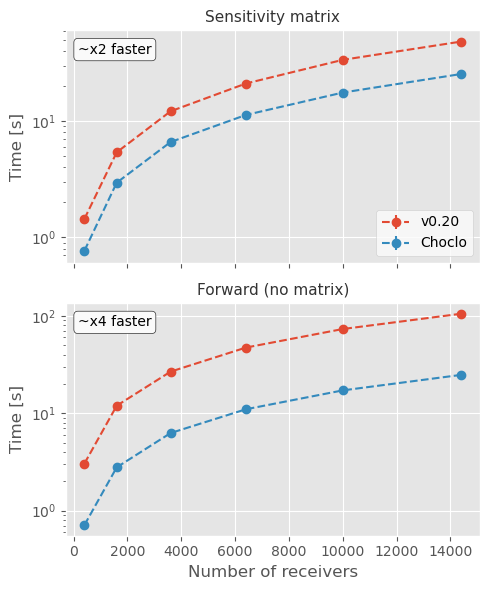

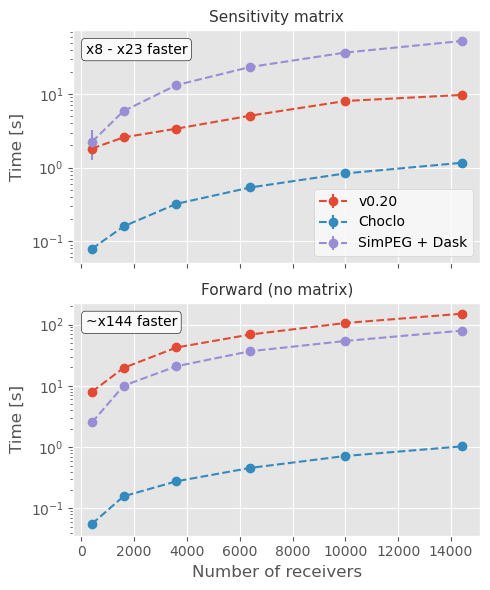

In [9]:
for parallel in (False, True):
    ncols, nrows = 1, 2
    figsize = (5, 6)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, sharex=True)

    for row, simulation_type in zip(range(nrows), dataset.simulation_type):
        ax = axes[row]
        
        # Plot benchmark results
        for engine in dataset.engine:
            results = dataset.sel(
                engine=engine, simulation_type=simulation_type, parallel=parallel
            )
            ax.errorbar(
                x=results.n_receivers,
                y=results.times,
                yerr=results.errors,
                marker="o",
                linestyle="dashed",
                label=engine_to_str[str(engine.values)],
            )
            
        # Plot benchmarks with Dask
        if parallel:
            results = dataset_dask.sel(simulation_type=simulation_type)
            ax.errorbar(
                x=results.n_receivers,
                y=results.times,
                yerr=results.errors,
                marker="o",
                linestyle="dashed",
                label="SimPEG + Dask",
            )
            
        # Set title
        sim_type_str = str(simulation_type.values)
        if sim_type_str == "forward_only":
            sim_type_str = "Forward (no matrix)"
        elif sim_type_str == "ram":
            sim_type_str = "Sensitivity matrix"
        ax.set_title(sim_type_str)

        if row == 1:
            ax.set_xlabel("Number of receivers")
        ax.set_ylabel("Time [s]")

        # Annotate ratio
        times = dataset.times.sel(simulation_type=simulation_type, parallel=parallel)
        ratio = times.sel(engine="geoana") / times.sel(engine="choclo")
        vmin, vmax = np.min(ratio.values), np.max(ratio.values)
        if vmax / vmin < 1.4:
            text = f"~x{round(np.mean(ratio.values))} faster"
        else:
            text = f"x{round(vmin)} - x{round(vmax)} faster"

        ha = "left"
        if row == 0:
            loc = (0.03, 0.9)
        else:
            loc = (0.03, 0.9)

        ax.annotate(
            text,
            loc,
            xycoords="axes fraction",
            bbox=dict(boxstyle="round", fc="#fafafa", ec="#2e2e2e", alpha=1),
            ha=ha,
        )
        # ----------------

        # Add legend
        if row == 0:
            ax.legend(loc="lower right")

        # Set yscales
        ax.set_yscale("log")

    plt.tight_layout()

    # Save to disk
    if parallel:
        parallel_str = "parallel"
    else:
        parallel_str = "serial"

    plt.savefig(figs_dir / f"benchmark_n-receivers_{parallel_str}.png", dpi=figs_dpi)

    plt.show()

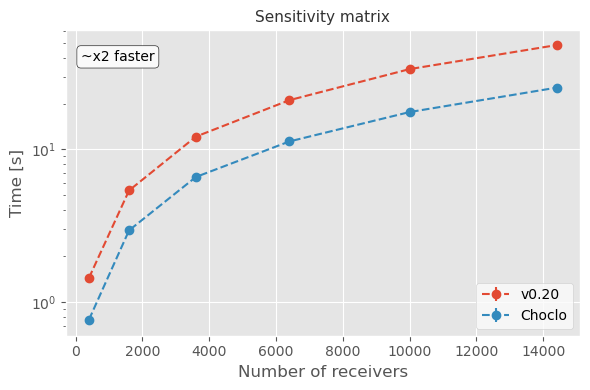

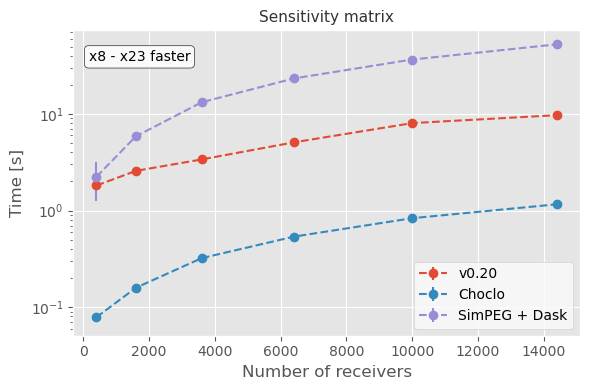

In [10]:
simulation_type = "ram"
figsize = (6, 4)


for parallel in (False, True):
    
    fig, ax = plt.subplots(figsize=figsize)

        
    # Plot benchmark results
    for engine in dataset.engine:
        results = dataset.sel(
            engine=engine, simulation_type=simulation_type, parallel=parallel
        )

        ax.errorbar(
            x=results.n_receivers,
            y=results.times,
            yerr=results.errors,
            marker="o",
            linestyle="dashed",
            label=engine_to_str[str(engine.values)],
        )

    # Plot benchmarks with Dask
    if parallel:
        results = dataset_dask.sel(simulation_type=simulation_type)
        ax.errorbar(
            x=results.n_receivers,
            y=results.times,
            yerr=results.errors,
            marker="o",
            linestyle="dashed",
            label="SimPEG + Dask",
        )

    # Set title
    ax.set_title("Sensitivity matrix")

    ax.set_xlabel("Number of receivers")
    ax.set_ylabel("Time [s]")

    # Annotate ratio
    times = dataset.times.sel(simulation_type=simulation_type, parallel=parallel)
    ratio = times.sel(engine="geoana") / times.sel(engine="choclo")
    vmin, vmax = np.min(ratio.values), np.max(ratio.values)
    if vmax / vmin < 1.4:
        text = f"~x{round(np.mean(ratio.values))} faster"
    else:
        text = f"x{round(vmin)} - x{round(vmax)} faster"

    ha = "left"
    loc = (0.03, 0.9)
    ax.annotate(
        text,
        loc,
        xycoords="axes fraction",
        bbox=dict(boxstyle="round", fc="#fafafa", ec="#2e2e2e", alpha=1),
        ha=ha,
    )
    # ----------------

    # Add legend
    ax.legend(loc="lower right")
    
    # Set yscales
    ax.set_yscale("log")

    plt.tight_layout()

    # Save to disk
    if parallel:
        parallel_str = "parallel"
    else:
        parallel_str = "serial"

    plt.savefig(figs_dir / f"benchmark_n-receivers_sensitivities_{parallel_str}.png", dpi=figs_dpi)

    plt.show()

# Plot results against number of cells in the mesh

In [11]:
results_dir = Path("..") / "results"
fname = results_dir / "benchmark_n-cells.nc"

In [12]:
dataset = xr.load_dataset(fname)
dataset

<xarray.Dataset>
Dimensions:          (n_cells: 5, simulation_type: 2, engine: 2, parallel: 2)
Coordinates:
  * n_cells          (n_cells) int32 8000 64000 216000 512000 1000000
  * simulation_type  (simulation_type) object 'ram' 'forward_only'
  * engine           (engine) object 'geoana' 'choclo'
  * parallel         (parallel) bool False True
Data variables:
    times            (parallel, simulation_type, engine, n_cells) float64 2.5...
    errors           (parallel, simulation_type, engine, n_cells) float64 0.0...

In [13]:
fname = results_dir / "benchmark_dask-n-cells.nc"
dataset_dask = xr.load_dataset(fname)
dataset_dask

<xarray.Dataset>
Dimensions:          (n_cells: 5, simulation_type: 2)
Coordinates:
  * n_cells          (n_cells) int32 8000 64000 216000 512000 1000000
  * simulation_type  (simulation_type) object 'ram' 'forward_only'
Data variables:
    times            (simulation_type, n_cells) float64 8.24 10.98 ... 159.1
    errors           (simulation_type, n_cells) float64 0.03438 0.1582 ... 1.673

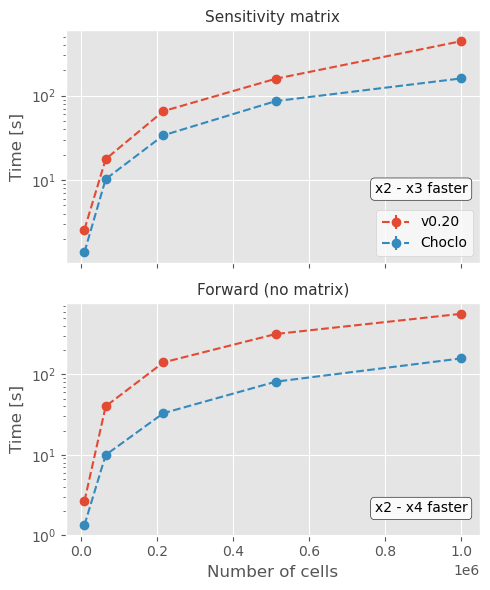

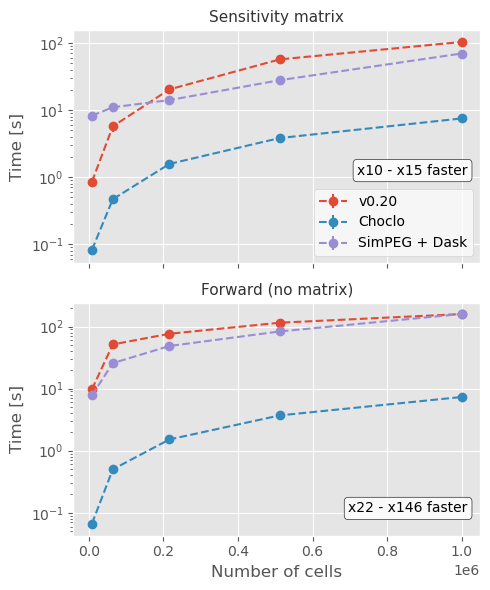

In [14]:
for parallel in (False, True):
    ncols, nrows = 1, 2
    figsize = (5, 6)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, sharex=True)

    for row, simulation_type in zip(range(nrows), dataset.simulation_type):
        ax = axes[row]
        for engine in dataset.engine:
            results = dataset.sel(
                engine=engine, simulation_type=simulation_type, parallel=parallel
            )
            ax.errorbar(
                x=results.n_cells,
                y=results.times,
                yerr=results.errors,
                marker="o",
                linestyle="dashed",
                label=engine_to_str[str(engine.values)],
            )
            
        if parallel:
            # Plot benchmarks with Dask
            results = dataset_dask.sel(simulation_type=simulation_type)
            ax.errorbar(
                x=results.n_cells,
                y=results.times,
                yerr=results.errors,
                marker="o",
                linestyle="dashed",
                label="SimPEG + Dask",
            )
            
        sim_type_str = str(simulation_type.values)
        if sim_type_str == "forward_only":
            sim_type_str = "Forward (no matrix)"
        elif sim_type_str == "ram":
            sim_type_str = "Sensitivity matrix"
        ax.set_title(sim_type_str)
        
        ax.set_ylabel("Time [s]")
        if row == 1:
            ax.set_xlabel("Number of cells")

        # Annotate ratio
        times = dataset.times.sel(simulation_type=simulation_type, parallel=parallel)
        ratio = times.sel(engine="geoana") / times.sel(engine="choclo")
        vmin, vmax = np.min(ratio.values), np.max(ratio.values)
        if vmax / vmin < 1.4:
            text = f"~x{round(np.mean(ratio.values))} faster"
        else:
            text = f"x{round(vmin)} - x{round(vmax)} faster"

        if not parallel:
            if row == 0:
                loc = (0.97, 0.3)
            else:
                loc = (0.97, 0.1)
        else:
            if row == 0:
                loc = (0.97, 0.38)
            else:
                loc = (0.97, 0.1)
        ha = "right"

        ax.annotate(
            text,
            loc,
            xycoords="axes fraction",
            bbox=dict(boxstyle="round", fc="#fafafa", ec="#2e2e2e", alpha=1),
            ha=ha,
        )
        # ---------------------------------

        # Add legend
        if row == 0:
            ax.legend(loc="lower right")

        # Set yscales
        ax.set_yscale("log")

    plt.tight_layout()

    # Save to disk
    if parallel:
        parallel_str = "parallel"
    else:
        parallel_str = "serial"
    plt.savefig(figs_dir / f"benchmark_n-cells_{parallel_str}.png", dpi=figs_dpi)

    plt.show()

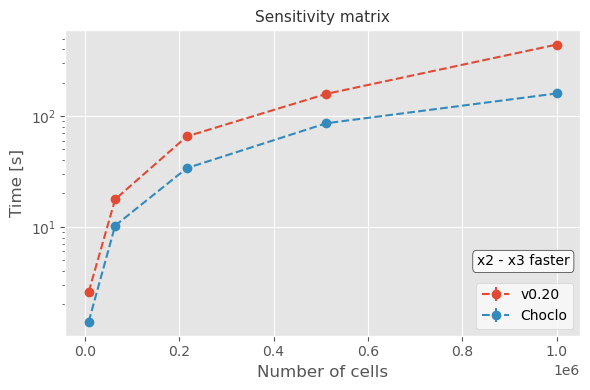

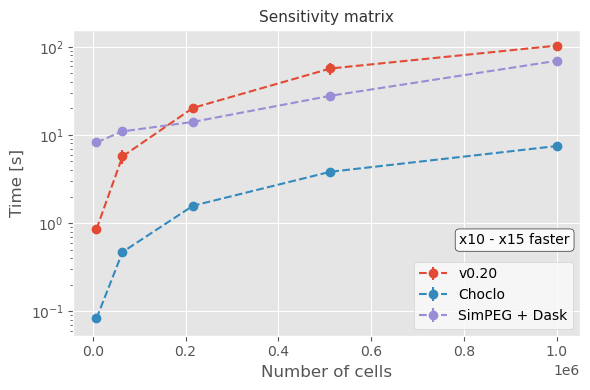

In [15]:
figsize = (6, 4)
simulation_type = "ram"

for parallel in (False, True):
    fig, ax = plt.subplots(figsize=figsize)

    for engine in dataset.engine:
        results = dataset.sel(
            engine=engine, simulation_type=simulation_type, parallel=parallel
        )
        ax.errorbar(
            x=results.n_cells,
            y=results.times,
            yerr=results.errors,
            marker="o",
            linestyle="dashed",
            label=engine_to_str[str(engine.values)],
        )
        
    if parallel:
        # Plot benchmarks with Dask
        results = dataset_dask.sel(simulation_type=simulation_type)
        ax.errorbar(
            x=results.n_cells,
            y=results.times,
            yerr=results.errors,
            marker="o",
            linestyle="dashed",
            label="SimPEG + Dask",
        )
            

    ax.set_title("Sensitivity matrix")
    ax.set_xlabel("Number of cells")
    ax.set_ylabel("Time [s]")

    # Annotate ratio
    times = dataset.times.sel(simulation_type=simulation_type, parallel=parallel)
    ratio = times.sel(engine="geoana") / times.sel(engine="choclo")
    vmin, vmax = np.min(ratio.values), np.max(ratio.values)
    if vmax / vmin < 1.4:
        text = f"~x{round(np.mean(ratio.values))} faster"
    else:
        text = f"x{round(vmin)} - x{round(vmax)} faster"

    if parallel:
        loc = (0.98, 0.3)
    else:
        loc = (0.98, 0.23)
    ha = "right"
    ax.annotate(
        text,
        loc,
        xycoords="axes fraction",
        bbox=dict(boxstyle="round", fc="#fafafa", ec="#2e2e2e", alpha=1),
        ha=ha,
    )
    # ---------------------------------

    # Add legend
    ax.legend(loc="lower right")

    # Set yscales
    ax.set_yscale("log")

    plt.tight_layout()

    # Save to disk
    if parallel:
        parallel_str = "parallel"
    else:
        parallel_str = "serial"
    plt.savefig(figs_dir / f"benchmark_n-cells_sensitivities_{parallel_str}.png", dpi=figs_dpi)

    plt.show()

# Plot results against number of processors used

In [16]:
results_dir = Path("..") / "results"
fname = results_dir / "benchmark_n-processes.nc"

In [17]:
dataset = xr.load_dataset(fname)
dataset

<xarray.Dataset>
Dimensions:          (n_processes: 6, simulation_type: 2, engine: 2)
Coordinates:
  * n_processes      (n_processes) int32 1 5 10 20 30 48
  * simulation_type  (simulation_type) object 'ram' 'forward_only'
  * engine           (engine) object 'geoana' 'choclo'
Data variables:
    times            (engine, simulation_type, n_processes) float64 73.42 ......
    errors           (engine, simulation_type, n_processes) float64 1.876 ......

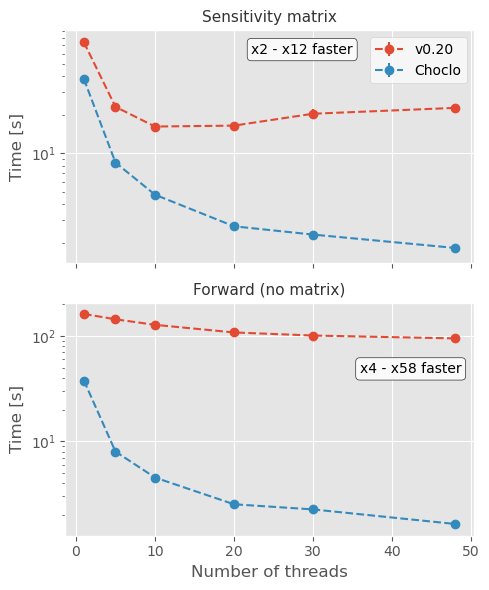

In [18]:
ncols, nrows = 1, 2
figsize = (5, 6)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, sharex=True)

for row, simulation_type in zip(range(nrows), dataset.simulation_type):
    ax = axes[row]
    for engine in dataset.engine:
        results = dataset.sel(engine=engine, simulation_type=simulation_type)

        ax.errorbar(
            x=results.n_processes,
            y=results.times,
            yerr=results.errors,
            marker="o",
            linestyle="dashed",
            label=engine_to_str[str(engine.values)],
        )
    sim_type_str = str(simulation_type.values)
    if sim_type_str == "forward_only":
        sim_type_str = "Forward (no matrix)"
    elif sim_type_str == "ram":
        sim_type_str = "Sensitivity matrix"
    ax.set_title(sim_type_str)

    ax.set_ylabel("Time [s]")

    # Annotate ratio
    times = dataset.times.sel(simulation_type=simulation_type)
    ratio = times.sel(engine="geoana") / times.sel(engine="choclo")
    vmin, vmax = np.min(ratio.values), np.max(ratio.values)
    if vmax / vmin < 1.4:
        text = f"~x{round(np.mean(ratio.values))} faster"
    else:
        text = f"x{round(vmin)} - x{round(vmax)} faster"

    if row == 0:
        loc = (0.58, 0.9)
        ha = "center"
    else:
        loc = (0.97, 0.7)
        ha = "right"

    ax.annotate(
        text,
        loc,
        xycoords="axes fraction",
        bbox=dict(boxstyle="round", fc="#fafafa", ec="#2e2e2e", alpha=1),
        ha=ha,
    )
    # ---------------------------------

    # Add legend
    if row == 0:
        ax.legend(loc="upper right")
    if row == 1:
        ax.set_xlabel("Number of threads")
    ax.set_yscale("log")

    # Set yscales
    ax.set_yscale("log")

plt.tight_layout()

plt.savefig(figs_dir / "benchmark_n-processes.png", dpi=figs_dpi)

plt.show()